## Bounding box augmentation for object detection ##

In [1]:
import os
import sys
import glob
import logging
import json
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import cv2

import albumentations as alb

logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

%load_ext autoreload
%autoreload 2
import computervision
from computervision.dentex import Dentex
from computervision.imageproc import ImageData

# Print version info
print(f'Package version: {computervision.__version__}')
print(f'Python version:  {sys.version}')

Package version: v0.0.1
Python version:  3.12.3 (main, Jun 18 2025, 17:59:45) [GCC 13.3.0]


In [2]:
data_dir = os.path.join(os.environ.get('HOME'), 'data')
print(f'data_dir: {data_dir}')

# Directory to store the data
dataset_dir = os.path.join(data_dir, 'dentex')

# After extraction from the .tar.gz archive, the images should be on the local fs (see the first notebook)
xrays_dir = os.path.join(dataset_dir, 'cropped')

data_dir: /app/data


## Load the annotations ##

In [3]:
parquet_file_name = 'train_quadrant_enumeration_cropped.parquet'
parquet_file = os.path.join(xrays_dir, parquet_file_name)
try:
    df = pd.read_parquet(parquet_file)
except Exception as e:
    print(f'ERROR: Could not load file: \n {e}')
    print('Make sure to run the first notebook which downloads the data.')
display(df.head())

,bbox,segmentation,height,width,file_name,file_base_name,quadrants,quadrant,pos,fdi,ada
0,"[666, 102, 103, 376]","[[757, 478, 769, 102, 678, 113, 666, 469]]",494,1473,train_0_12.png,train_0,12,1,1,11,8
1,"[593, 107, 85, 377]","[[666, 484, 678, 110, 607, 107, 604, 299, 619,...",494,1473,train_0_12.png,train_0,12,1,2,12,7
2,"[531, 69, 85, 368]","[[587, 437, 616, 357, 607, 72, 534, 69, 531, 4...",494,1473,train_0_12.png,train_0,12,1,3,13,6
3,"[457, 31, 115, 403]","[[522, 434, 572, 378, 543, 31, 463, 40, 457, 3...",494,1473,train_0_12.png,train_0,12,1,4,14,5
4,"[369, 10, 100, 406]","[[437, 416, 469, 378, 466, 10, 381, 31, 378, 2...",494,1473,train_0_12.png,train_0,12,1,5,15,4


In [4]:
# Let's make sure that we have the expected number of images available
# If the image numbers don't match, please run the first three notebooks.

expected_images = len(df['file_name'].unique())
file_list = glob.glob(os.path.join(xrays_dir, '*.png'))
print(f'Found {len(file_list)} images in {xrays_dir}')
print(f'Expected number of images is {expected_images}.')

# We want to be sure that the number of images is correct before we continue
assert expected_images == len(file_list), \
    f'WARNING: expected images ({expected_images}) != images on file system ({len(file_list)})'

Found 2534 images in /app/data/dentex/cropped
Expected number of images is 2534.


### Bounding box format ###

In [5]:
# Function to plot an image with the bounding boxes
def plot_boxes(image, box_list, ax, label_list=None, color=None, cmap='grey'):
    offset_xy = (10, 100)
    # Take a ratio that looks good
    offset = (image.shape[1]*offset_xy[0]/2500,
              image.shape[0]*offset_xy[1]/1250)
    if color is None:
        # If no color is provided, color each box in a different color
        color_list = list(plt.cm.rainbow(np.linspace(0, 1, len(box_list))))
    else:
        color_list = [color]*len(box_list)
    ax.set(xticks=[], yticks=[])
    ax.imshow(image, cmap=cmap)
    # Loop over the bounding boxes
    for b, box in enumerate(box_list):
        rect = Rectangle(xy=(box[0], box[1]),
                         width=box[2],
                         height=box[3],
                         linewidth=1.5,
                         edgecolor=color_list[b],
                         facecolor='none',
                         alpha=0.7)
        ax.add_patch(rect)
        if label_list is not None:
            ax.text(x=box[0]+offset[0], y=box[1]+offset[1], s=label_list[b], color=color_list[b], fontsize=8)
    return ax

### Augmenting bounding boxes ###

In [8]:
# Bounding box format definition
box_format = {'format': 'coco',
              'label_fields': ['quadrant', 'position']}
bbox_params = alb.BboxParams(**box_format)
display(bbox_params)

BboxParams(format=coco, label_fields=['quadrant', 'position'], min_area=0.0, min_visibility=0.0, min_width=0.0, min_height=0.0, check_each_transform=True, clip=False)

train_209
Image file for xray train_209 and quadrants 14: train_209_14.png
(725, 710, 3)


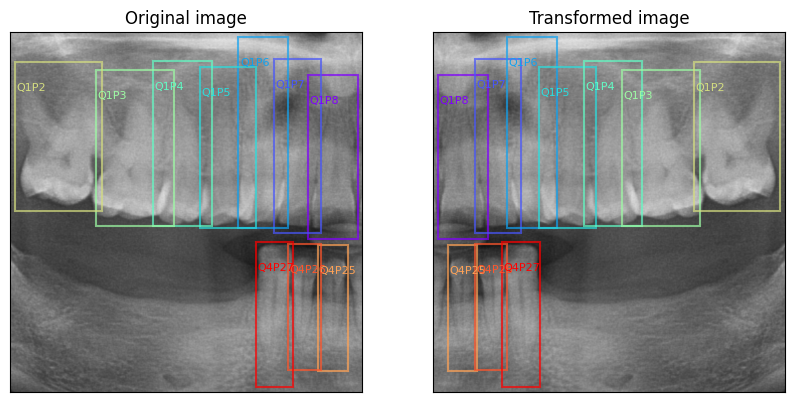

In [9]:
# Pick a panoramic image
idx = 123
file_base_name = sorted(list(df['file_base_name'].unique()))[idx]
print(file_base_name)

# Pick a quadrant
quadrants = 14
# The data frame with the bounding boxes
df_file = df.loc[(df['file_base_name'] == file_base_name) & (df['quadrants'] == quadrants)]
file_name = df_file['file_name'].tolist()[0]
print(f'Image file for xray {file_base_name} and quadrants {quadrants}: {file_name}')

# Load the image
file = os.path.join(xrays_dir, file_name)
im = ImageData().load_image(file)
# For the model, we need RGB images
im = ImageData().np2color(im)
print(im.shape)

# Prepare bounding boxes
# Each row is [x_min, x_max, bbox_width, bbox_height]
box_list = df_file['bbox'].tolist()
bboxes = np.array(box_list)

# Use two categories of annotations: quadrants and positions
quadrant_list = df_file['quadrant'].tolist()
position_list = df_file['ada'].tolist()
labels = {'quadrant': quadrant_list,
          'position': position_list}
label_list = [f'Q{q}P{p}' for q, p in zip(quadrant_list, position_list)]

# Just one transformation for demonstration
transformation_list = [alb.HorizontalFlip(p=1.0)]
alb_transform = alb.Compose(transformation_list, bbox_params=bbox_params)

# Carry out the transformation
transformed = alb_transform(image=im, bboxes=bboxes, **labels)

# Retrieve the image and annotations of the transformed image
transformed_image = transformed['image']
transformed_box_list = list(transformed['bboxes'])
transformed_quadrant_list = list(np.array(transformed['quadrant']).astype(int))
transformed_position_list = list(np.array(transformed['position']).astype(int))
transformed_label_list = [f'Q{q}P{p}' for q, p in zip(transformed_quadrant_list, 
                                                      transformed_position_list)]

# Lets plot the image with the bounding boxes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0] = plot_boxes(image=im, box_list=box_list, label_list=label_list, ax=ax[0])
ax[1] = plot_boxes(image=transformed_image, box_list=transformed_box_list, label_list=transformed_label_list, ax=ax[1])
ax[0].set(title='Original image')
ax[1].set(title='Transformed image')
plt.show()

In [10]:
# Create a function to carry out the transformations and plot the results
def transform(image, boxes, quadrants, positions, transformations):
    try:
        assert all(isinstance(var, list) for var in [boxes, quadrants, positions, transformations])
    except AssertionError:
        logging.error(f'boxes, quadrants, positions and transformations should be lists: {e}')
    
    # Define the bounding annotation format
    box_format = {'format': 'coco', 'label_fields': ['quadrants', 'positions']}

    # Now, format the boundig boxes and labels
    bboxes = np.array(boxes)
    assert len(bboxes.shape) == 2 and bboxes.shape[1] == 4
    labels = {'quadrants': quadrants, 'positions': positions}
    
    # Set up the tranformation with the bounding boxes (careful: not all transformations support bounding boxes!)
    transform = alb.Compose(transformations, bbox_params=alb.BboxParams(**box_format))
    
    # Carry out the transformation
    transformed = transform(image=image, bboxes=bboxes, **labels)

    # Prepare the output as a dictionary
    output = {'image': transformed['image'], 
              'boxes': list(transformed['bboxes'].astype(int)),
              'quadrants': list(np.array(transformed['quadrants']).astype(int)), 
              'positions': list(np.array(transformed['positions']).astype(int))}

    return output

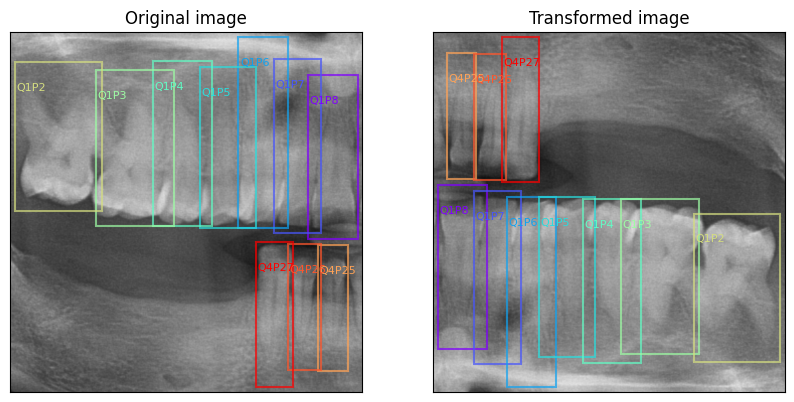

In [11]:
# Try the function
boxes = df_file['bbox'].tolist()
quadrants = df_file['quadrant'].tolist()
positions = df_file['ada'].tolist()

transformations = [alb.HorizontalFlip(p=1.0), alb.VerticalFlip(p=1)]
output = transform(image=im, boxes=boxes, quadrants=quadrants, positions=positions, transformations=transformations)

# Format the labels
labels = [f'Q{q}P{p}' for q, p in zip(quadrants, positions)]
transformed_labels = [f'Q{q}P{p}' for q, p in zip(output['quadrants'], output['positions'])]

# Plot the output
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0] = plot_boxes(image=im, box_list=boxes, label_list=labels, ax=ax[0])
ax[1] = plot_boxes(image=output['image'], box_list=output['boxes'], label_list=transformed_labels, ax=ax[1])
ax[0].set(title='Original image')
ax[1].set(title='Transformed image')
plt.show()

### Bounding Box Augmentation for Object Detection ###

In [12]:
# Pick a panoramic image
file_idx = 12
file_base_name = sorted(list(df['file_base_name'].unique()))[file_idx]
# Pick a quadrant
quadrants = 14
# Data frame with the annotations
df_file = df.loc[(df['file_base_name'] == file_base_name) & (df['quadrants'] == quadrants)]

# Bounding boxes and annotations
boxes = df_file['bbox'].tolist()
quadrants = df_file['quadrant'].tolist()
positions = df_file['ada'].tolist()
labels = [f'Q{q}P{p}' for q, p in zip(quadrants, positions)]

# Load the image
file = os.path.join(xrays_dir, df_file['file_name'].tolist()[0])
im = ImageData().load_image(file)
im = ImageData().np2color(im)

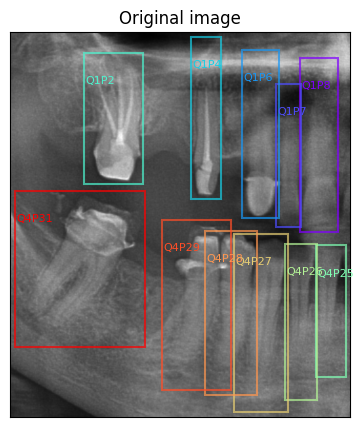

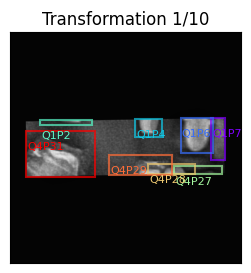

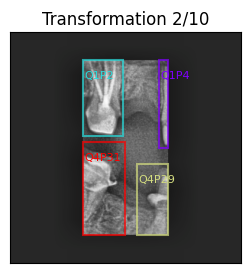

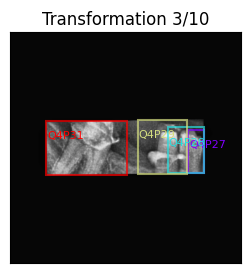

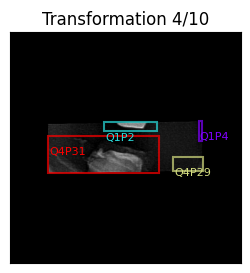

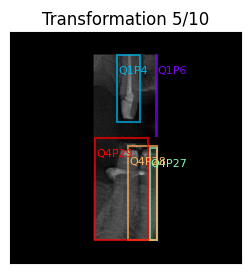

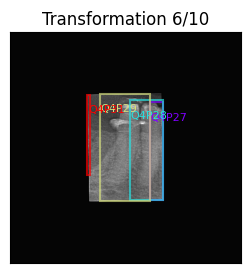

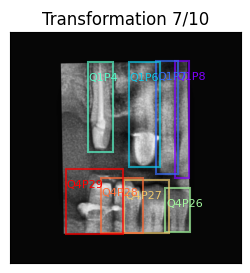

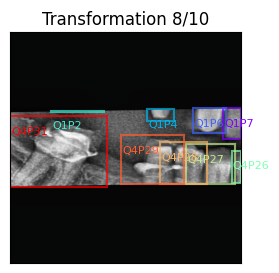

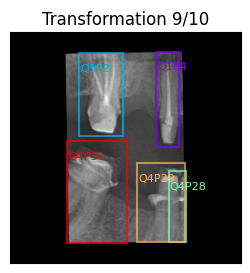

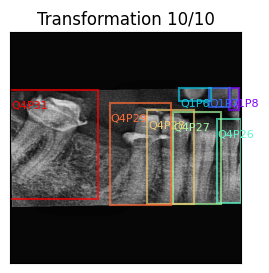

In [13]:
# Crop to the output format
im_size = 640
transformations = [alb.RandomCropFromBorders(crop_left=0.5, crop_right=0.5, crop_top=0.5, crop_bottom=0.5, p=1.0),
                   alb.CenterCrop(height=im_size, width=im_size, pad_if_needed=True),
                   alb.Affine(scale=(0.8, 1.2), rotate=1, p=0.5),
                   alb.RandomBrightnessContrast(p=0.5),
                   alb.Sharpen(p=0.5),
                   alb.CLAHE(p=0.5)]

# Plot the original image with bounding boxes
fig, ax = plt.subplots(figsize=(7, 5))
ax = plot_boxes(image=im, box_list=boxes, label_list=labels, ax=ax)
ax.set(title='Original image')
plt.show()

# Plot the augmentations
# Run the augmentations multiple times
runs = 10
for r in range(runs):
    
    # Run the transformation
    output = transform(image=im, boxes=boxes, quadrants=quadrants, positions=positions, transformations=transformations)
    transformed_labels = [f'Q{q}P{p}' for q, p in zip(output['quadrants'], output['positions'])]

    # Plot the output
    fig, ax = plt.subplots(figsize=(3, 3))
    ax = plot_boxes(image=output['image'], box_list=output['boxes'], label_list=transformed_labels, ax=ax)
    ax.set(title=f'Transformation {r+1}/{runs}')
    plt.show()